In [1]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab.patches import cv2_imshow
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import ops
from keras import layers

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print('x_train shape', x_train.shape)
print('y_train shape', y_train.shape)
print('x_test shape', x_test.shape)
print('y_test shape', y_test.shape)

x_train shape (60000, 28, 28)
y_train shape (60000,)
x_test shape (10000, 28, 28)
y_test shape (10000,)


In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
#normalization: original input range: 0-255 / new input range: 0-1
x_train_norm = x_train.astype('float32')/255
x_test_norm = x_test.astype('float32')/255

In [7]:
x_train_norm = np.expand_dims(x_train_norm, axis=-1)
x_test_norm = np.expand_dims(x_test_norm, axis=-1)

In [8]:
print('x_train reshaped', x_train_norm.shape)
print('x_test shape', x_test_norm.shape)

x_train reshaped (60000, 28, 28, 1)
x_test shape (10000, 28, 28, 1)


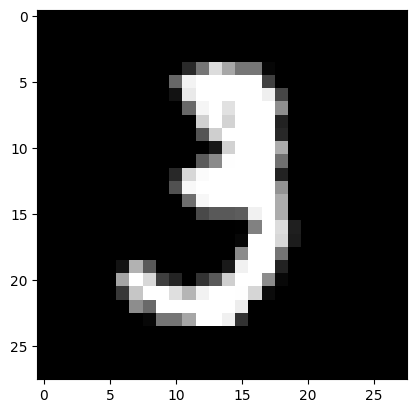

In [9]:
plt.imshow(x_train_norm[10], cmap='gray')

In [10]:
y_train = keras.utils.to_categorical(y_train, 10)

In [11]:
print(y_train.shape)

(60000, 10)


# build the CNN CVAE

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [13]:
latent_dim = 2  # Adjust as needed

In [15]:
#encoder
encoder_image_input = keras.Input(shape=(28, 28, 1))

encoder_label_input = keras.Input(shape=(10,))
x = layers.Dense(28 * 28 * 1, activation="relu")(encoder_label_input)
x = layers.Reshape((28, 28, 1))(x)

x = layers.concatenate([encoder_image_input, x], axis=-1)
#(28,28,2)

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
#(14,14,32)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
#(7,7,64)
x = layers.Flatten()(x)
#7*7*64
x = layers.Dense(16, activation="relu")(x)
#16
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
#encoder model
encoder = keras.Model([encoder_image_input, encoder_label_input] , [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 784)            │          8,624 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 28, 28, 1)      │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 28, 28, 2)      │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 32)     │            608 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 3136)           │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 16)             │         50,192 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 77,988 (304.64 KB)

 Trainable params: 77,988 (304.64 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#decoder
latent_inputs = keras.Input(shape=(latent_dim,))

decoder_label_input = keras.Input(shape=(10,))

x = layers.concatenate([latent_inputs, decoder_label_input], axis=-1)
#12
x = layers.Dense(7 * 7 * 64, activation="relu")(x)
#7*7*64
x = layers.Reshape((7, 7, 64))(x)
#(7,7,64)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
#(14,14,64)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
#(28,28,32)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
#(28,28,1)
#decoder_model
decoder = keras.Model([latent_inputs, decoder_label_input], decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 12)             │              0 │ input_layer_6[0][0],   │
│ (Concatenate)             │                        │                │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 3136)           │         40,768 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 7, 7, 64)       │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 14, 14, 64)     │         36,928 │ reshape_3[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 28, 28, 32)     │         18,464 │ conv2d_transpose_3[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 28, 28, 1)      │            289 │ conv2d_transpose_4[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 96,449 (376.75 KB)

 Trainable params: 96,449 (376.75 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder([z, data[0][1]]) #data[0][1] is the input lable (condition vector)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data[0][0], reconstruction), #data[0][0] is the input image
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        #backpropagation algo
        grads = tape.gradient(total_loss, self.trainable_weights)
        #optimization: updte the wwights and biases using the optimizer function
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [24]:
my_model = VAE(encoder, decoder)

In [25]:
my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [26]:
# fit without augmentations
history = my_model.fit(x=[x_train_norm, y_train],
                        batch_size=128,
                        epochs=30,
                        verbose=1)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - kl_loss: 1.0153 - loss: 240.8719 - reconstruction_loss: 239.8566
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 2.7762 - loss: 152.4783 - reconstruction_loss: 149.7021
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 2.6343 - loss: 148.6580 - reconstruction_loss: 146.0238
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - kl_loss: 2.6005 - loss: 147.1820 - reconstruction_loss: 144.5815
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 2.5363 - loss: 146.9681 - reconstruction_loss: 144.4317
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 2.5096 - loss: 146.4367 - reconstruction_loss: 143.9270
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 3.6645 - loss: 140.4841 - reconstruction_loss: 136.8196
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.4360 - loss: 133.4384 - reconstruction_loss: 129.0024
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms

#image generation

In [48]:
test_z = np.random.uniform(-1, 1, size=(1,2))
print(test_z)
condition = 9
condition = keras.utils.to_categorical(condition, 10)
condition = np.expand_dims(condition, axis=0)
print(condition)

[[-0.33937045  0.90034644]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [49]:
pred = my_model.decoder.predict([test_z, condition])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


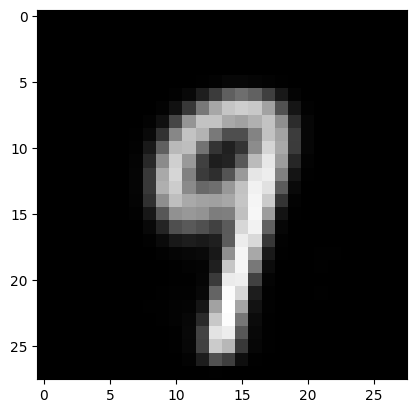

In [50]:
plt.imshow(pred[0], cmap='gray')

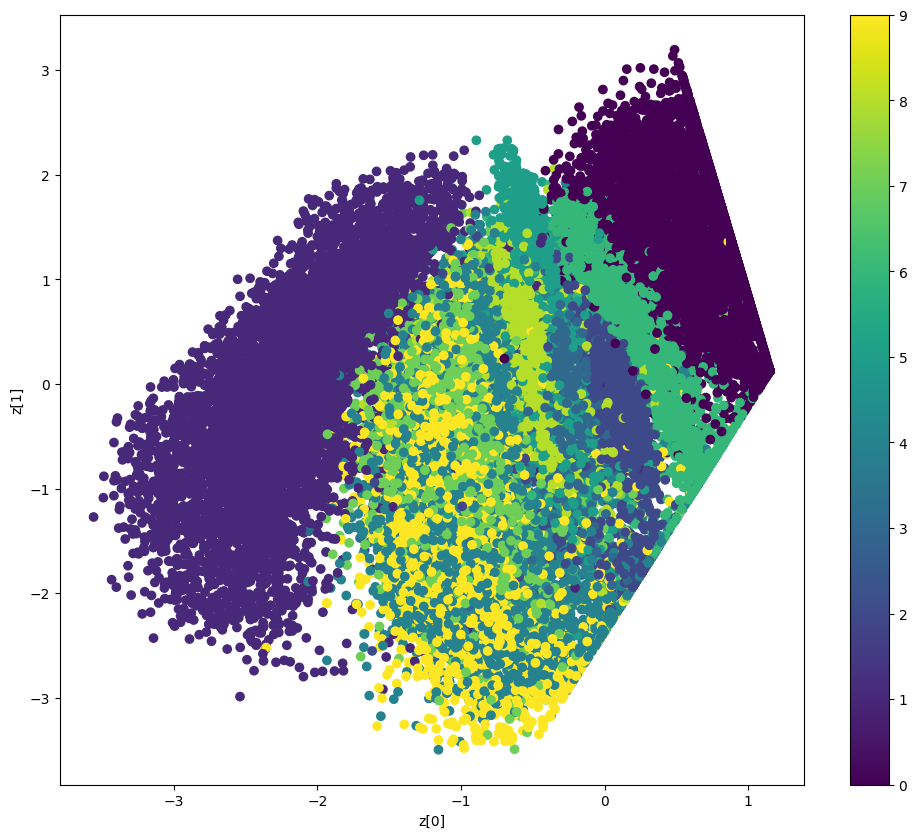

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = my_model.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(my_model, x_train, y_train)